<a href="https://colab.research.google.com/github/pea-sys/Til/blob/master/Advanced_Python_%E6%99%82%E7%B3%BB%E5%88%97%E8%A7%A3%E6%9E%90_Chapter_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[元ネタ](https://www.kyoritsu-pub.co.jp/bookdetail/9784320125018)

In [50]:
!pip install pandas==0.24.2

In [0]:
import google.colab
import googleapiclient.discovery
import googleapiclient.http
google.colab.auth.authenticate_user()
drive_service = googleapiclient.discovery.build('drive', 'v3')

In [0]:
def gdrive_dl(filename):
  upload_filename = filename

  file_list = drive_service.files().list(q="name='" + upload_filename + "'").execute().get('files')

  # ファイル ID を取得します。
  file_id = None
  for file in file_list:
    if file.get('name') == upload_filename:
      file_id = file.get('id')
      break

  if file_id is None:
    # ファイル ID を取得できなかった場合はエラーメッセージを出力します。
    print(upload_filename + ' が見つかりません.')
  else:
    # colab 環境へファイルをアップロードします。
    with open(upload_filename, 'wb') as f:
      request = drive_service.files().get_media(fileId=file_id)
      media = googleapiclient.http.MediaIoBaseDownload(f, request)

      done = False
      while not done:
        progress_status, done = media.next_chunk()
        print(100*progress_status.progress(), end="")
        print("%完了")

    print('GoogleドライブからColab環境へのファイル取り込みが完了しました.')

def gdrive_up(filename):

  file_metadata = {'name': filename,'mimeType': 'application/octet-stream'}
  media = googleapiclient.http.MediaFileUpload(filename,mimetype='application/octet-stream',resumable=True)
  created = drive_service.files().create(body=file_metadata,media_body=media, fields='id').execute()

In [0]:
%matplotlib inline
import matplotlib.pyplot as ply
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#1.4 加法モデルと乗法モデル
時系列データは次の３つの変動成分の合成であると考えることができる

*   T;傾向変動(トレンド)・・・時間とともに単調に増加・減少する変動。長期的、系統的な変動
*   S;季節変動・・・季節によって左右される変動。一年を周期として規則的に繰り返される変動。曜日変動など他のサイクリックな変動にも同じ考えが適用できる。
*   I;不規則変動・・・上記以外の説明がつかない不規則かつ短期間に起こる少変動。

加法モデルは以下が成立する。
```
原系列(O) = 傾向変動(T) + 季節変動(S) + 不規則変動(I)
```
乗法モデルは以下が成立する。
```
原系列(O) = 傾向変動(T) x 季節変動(S) x 不規則変動(I)
``` 
加法モデルは季節変動の幅は一定になり、加法モデルは原系列の大きさに応じて、季節変動の幅が変化する。


In [0]:
import io
import requests
import statsmodels.api as sm

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
content = pd.read_csv(io.StringIO(stream.decode('utf-8')))
passengers = content['#Passengers']

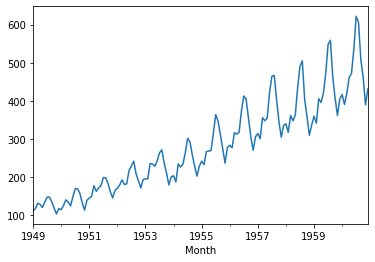

In [55]:
pd_content = content.copy()
pd_content['Month'] = pd.to_datetime(pd_content['Month'], infer_datetime_format=True)
pd_content.index = pd_content.Month
pd_content['#Passengers'].plot()

In [56]:
df_passenger = pd.DataFrame(content['#Passengers'].values.astype(int), 
                            pd.DatetimeIndex(start='1949-01',
                                             periods=len(content['#Passengers']), 
                                             freq='M'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  after removing the cwd from sys.path.


## 加法モデル

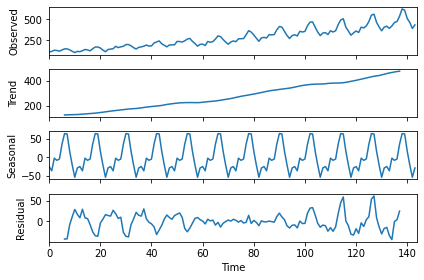

In [57]:
ts = sm.tsa.seasonal_decompose(df_passenger.values, freq=12)
tmp = ts.plot()

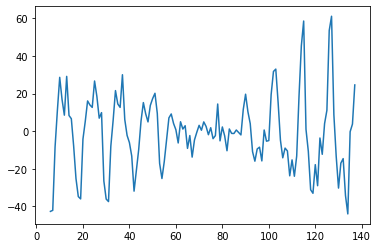

In [58]:
restoration = ts.trend + ts.seasonal
res = df_passenger.values.flatten()[6:-6] - restoration.flatten()[6:-6]

# 傾向変動+季節変動と観測データとの差分
plt.plot([np.float('nan')]*6 + res.tolist() + [np.float('nan')]*6)

## 乗法モデル

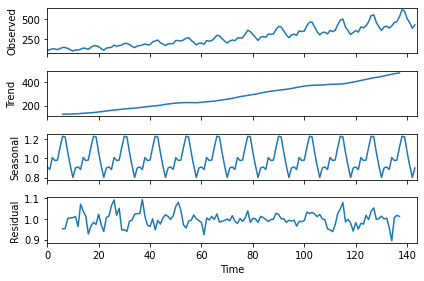

In [59]:
ts_mult = sm.tsa.seasonal_decompose(df_passenger.values, freq=12,  model='multiplicative')
tmp = ts_mult.plot()

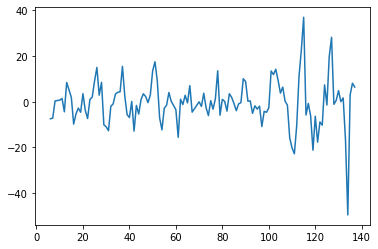

In [60]:
restoration_mult = ts_mult.trend * ts_mult.seasonal
res_mult = df_passenger.values.flatten()[6:-6] - restoration_mult.flatten()[6:-6]

# 傾向変動*季節変動と観測データとの差分
plt.plot([np.float('nan')]*6 + res_mult.tolist() + [np.float('nan')]*6)

グラフの縦軸が倍率に変わってます。
今回の原系列は乗法モデルの方が当てはまりが良いです。

#1.5 移動平均(時系列変動の平滑化)
誤差変動のキャンセルアウト  

In [61]:
#https://www.mizuhobank.co.jp/market/historical.html
gdrive_dl('m_quote.csv')
df = pd.read_csv('m_quote.csv', encoding="shift-jis",header=1)
df.sample(5)

100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.


,Unnamed: 0,USD,GBP,EUR,CAD,CHF,SEK,DKK,NOK,AUD,NZD,ZAR,BHD,IDR(100),CNY,HKD,INR,MYR,PHP,SGD,KRW(100),THB,KWD,SAR,AED,MXN,PGK,HUF,CZK,PLN,RUB,TRY,IDR(100).1,CNY.1,MYR.1,KRW(100).1,TWD
110,2011/6/30,80.57,130.78,115.95,82.43,95.79,12.74,15.55,14.81,85.51,65.67,11.87,213.96,*****,*****,10.35,1.80,*****,1.86,65.28,*****,2.64,293.60,21.49,21.94,6.83,34.81,0.44,4.79,29.25,2.88,50.34,0.94,12.44,26.63,7.46,2.80
210,2019/10/31,108.15,136.35,119.41,81.93,108.82,11.06,15.99,11.82,73.43,68.47,7.24,286.94,*****,15.24,13.79,1.52,*****,2.10,78.85,*****,3.56,356.14,28.83,29.45,5.59,32.62,0.36,4.65,27.75,1.68,18.70,0.77,*****,25.83,9.13,3.52
158,2015/6/30,123.77,192.59,138.77,100.12,132.84,14.96,18.60,15.85,95.48,86.59,10.07,328.62,*****,19.95,15.97,1.94,*****,2.75,91.98,*****,3.67,409.67,33.01,33.70,8.00,45.37,0.45,5.09,33.4,2.28,45.82,0.93,*****,33.13,11.12,4.01
150,2014/10/31,108.00,173.65,136.96,96.28,113.39,14.93,18.40,16.51,94.77,84.96,9.76,286.70,*****,17.6,13.92,1.77,*****,2.41,84.77,*****,3.33,374.28,28.80,29.41,8.01,43.24,0.45,4.98,32.58,2.65,47.96,0.89,*****,33.06,10.19,3.56
130,2013/2/28,93.23,144.35,124.60,92.48,101.28,14.65,16.70,16.79,96.21,78.29,10.51,247.50,*****,14.98,12.02,1.74,*****,2.30,75.29,*****,3.13,331.14,24.87,25.39,7.34,43.58,0.43,4.9,29.89,3.09,52.51,0.97,*****,30.1,8.59,3.15


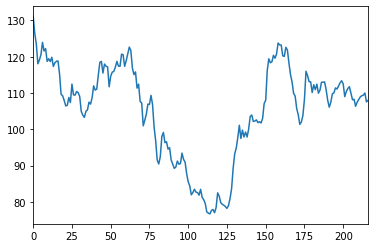

In [62]:
df.USD.plot()

rollingによる後方移動平均(対象時点とそれ以前の時点の値を使用して平均を計算)

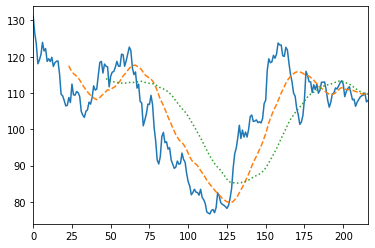

In [63]:
df.USD.plot()
df.USD.rolling(window=24).mean().plot(style='--')
df.USD.rolling(48).mean().plot(style=':')

# 1-6 中心化移動平均
原系列から季節変動パターンを取り除くために使用される

In [64]:
#https://oku.edu.mie-u.ac.jp/~okumura/stat/160118.html
gdrive_dl('icecream.csv')
df_ice = pd.read_csv('icecream.csv', encoding="shift-jis",header=1)
df_ice.head(5)

100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.


,年,月,アイスクリーム
0,2003,1,331
1,2003,2,268
2,2003,3,365
3,2003,4,492
4,2003,5,632


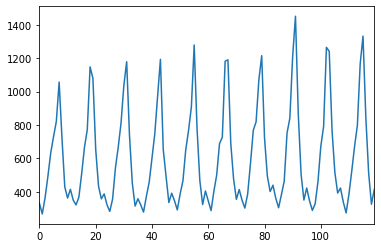

In [65]:
df_ice.アイスクリーム.plot()

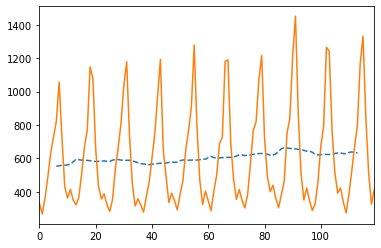

In [66]:
# 移動平均
df_ma = df_ice.アイスクリーム.rolling(window=12).mean().shift(-6)
# 中心化移動平均
df_cma = df_ma.rolling(window=2).mean()

# 中心化移動平均系列
df_cma.plot(style='--', label='CMA')
# 原系列
df_ice.アイスクリーム.plot(label='observation')

中心化移動平均は季節パターンを消し、トレンドのみを示す。


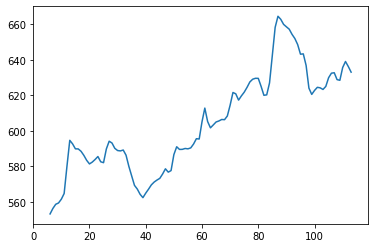

In [67]:
df_cma.plot()

# 1-7 季節調整
季節変動を除去することを季節調整と呼ぶ。  
ここでは乗法モデルによる季節調整を行う。  
乗法モデルは次式で表せる。  

```
原系列(O) = 傾向変動(T) x 季節変動(S) x 不規則変動(I)
```
これからS成分のみを除けば良い。  
本項の例では以下の手順により季節調整を行う。


1.   中心化移動平均を求める（T系列の作成）
2.   原系列を中心化移動平均で除した値を求め100倍する（S x I 系列の作成）
3.   手順2で求めた値から12か月ごとの季節指数を求める。（S系列の作成）
     当該指数を求めるには、月ごとの平均値を求めた上でその和が1200になるように調整する。
4.   原系列を季節指数で割って100を掛け、季節調整済みの値とする、(T x I 系列の作成）
















In [68]:
# 原系列(df_ice.expenditure_yen)/中心化移動平均系列(df_cma) 
df_orig_div_cma = df_ice.アイスクリーム / df_cma

# 月毎に加算
orig_div_cma = df_orig_div_cma.values
s_index = np.zeros(12)
counter = np.zeros(12, dtype='i')
for idx in range(len(orig_div_cma)//12):
    # 12ヶ月ごとにデータを抽出
    cut_orig_div_cma = orig_div_cma[idx*12:(idx+1)*12]
    mask = cut_orig_div_cma!=cut_orig_div_cma
    # numpy.whereを使用して非数(nan)を0にして加算する
    counter += np.where(mask, 0, 1)
    s_index += np.where(mask, 0, cut_orig_div_cma)

# 加算結果の各月平均
s_index /= counter
# 全体を1200に合わせ季節指数を計算
s_index = s_index / s_index.sum() * 1200
s_index

array([ 57.05374632,  48.4935788 ,  61.87100094,  82.34066594,
       112.21945388, 129.50185932, 178.03993789, 201.78512364,
       122.39560152,  79.21403276,  59.2923283 ,  67.79267067])

8月は201.79であることから、年平均よりも季節効果により101.79%上澄みされると考えられる。

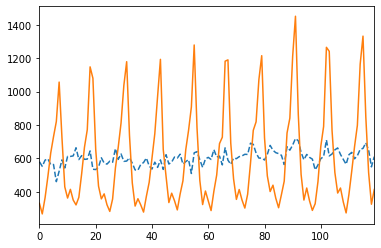

In [69]:
# 季節指数を原系列の要素と対応させる
# 原系列のスタートが1月なのでtileして12ヶ月分の季節指数を繰り返すだけで良い
tiled_s_index = np.tile(s_index, len(orig_div_cma)//12)

# 季節調整済み系列の計算
df_adjusted_series = df_ice.アイスクリーム / tiled_s_index * 100

# 季節調整済み系列
df_adjusted_series.plot(style='--', label='adjusted')
# 原系列
df_ice.アイスクリーム.plot(label='observation')

In [70]:
# 売上目標を年間1億とした場合の各月の達成目標額
goal = 100000000 / 1200 * s_index
goal

array([ 4754478.86030336,  4041131.56706274,  5155916.74538307,
        6861722.16182518,  9351621.15707162, 10791821.61036477,
       14836661.49123359, 16815426.96965148, 10199633.4598289 ,
        6601169.39664237,  4941027.35817998,  5649389.22245296])

#1-8 移動平均剥離率
移動平均剥離率は原系列と移動平均系列がどの程度離れているかを表す指標。トレンドからの剥離が大きい場合は、その先のデータはトレンドの方向に戻ってくると予想される。


```
移動平均剥離率 = (原系列の値 - 移動平均値) / 移動平均値 x 100
```



In [71]:
#https://www.mizuhobank.co.jp/market/historical.html
gdrive_dl('m_quote.csv')
df = pd.read_csv('m_quote.csv', encoding="shift-jis",header=1)
df.sample(5)

100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.


,Unnamed: 0,USD,GBP,EUR,CAD,CHF,SEK,DKK,NOK,AUD,NZD,ZAR,BHD,IDR(100),CNY,HKD,INR,MYR,PHP,SGD,KRW(100),THB,KWD,SAR,AED,MXN,PGK,HUF,CZK,PLN,RUB,TRY,IDR(100).1,CNY.1,MYR.1,KRW(100).1,TWD
66,2007/10/31,115.80,236.64,164.73,118.46,98.60,17.96,22.11,21.44,103.99,87.96,17.13,308.36,*****,*****,14.93,2.95,*****,2.62,78.96,*****,3.68,416.06,30.98,31.56,10.71,42.19,0.66,6.0334,44.49,NaN,NaN,1.27,15.43,34.3,12.67,3.56
7,2002/11/29,121.57,191.16,121.79,77.31,83.00,13.43,16.40,16.65,68.25,60.41,12.65,323.14,*****,*****,15.59,2.53,*****,2.29,68.91,10.05,2.81,405.90,32.43,33.11,11.94,*****,*****,*****,*****,NaN,NaN,1.36,14.69,*****,10.05,3.53
213,2020/1/31,109.39,142.93,121.35,83.60,112.82,11.50,16.24,12.21,74.95,72.20,7.59,290.24,*****,15.8,14.07,1.54,*****,2.15,80.96,*****,3.59,360.57,29.16,29.79,5.82,32.99,0.36,4.82,28.57,1.77,18.47,0.80,*****,26.83,9.38,3.65
57,2007/1/31,120.69,236.46,156.48,102.58,96.86,17.22,21.00,18.90,94.38,83.82,16.79,321.16,*****,*****,15.47,2.73,*****,2.47,78.46,*****,3.45,419.28,32.20,32.87,11.02,42.79,0.62,5.6252,40.31,NaN,NaN,1.34,15.49,34.42,12.88,3.69
118,2012/2/29,78.40,123.86,103.67,78.57,85.90,11.76,13.95,13.71,84.07,65.40,10.25,208.20,*****,*****,10.11,1.60,*****,1.84,62.54,*****,2.55,282.56,20.91,21.35,6.13,37.92,0.36,4.15,24.83,2.63,44.62,0.87,12.44,25.95,6.98,2.66


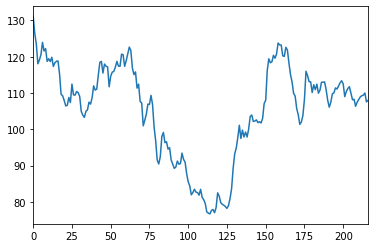

In [72]:
df.USD.plot(label='original')

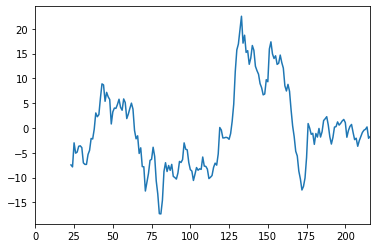

In [73]:
ma24 = df.USD.rolling(24).mean()
diff_ma24 = (df.USD - ma24) / ma24 * 100
diff_ma24.plot(label='deviation_rate')

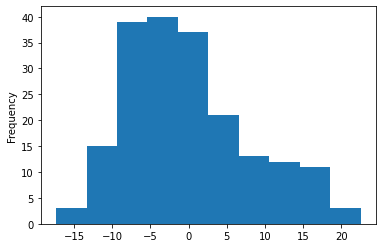

In [74]:
diff_ma24.plot.hist()

剥離率-15%と20%は稀である

#1-9 時期列データの基本統計量と前処理
データの前提確認において、客観的な判断を下す手法である統計的仮説検定について説明する。  
統計的仮説検定とは、同時に起こることのない（互いに背反な）２つの仮説（帰無仮説と対立仮説）を立て、データに基づいてどちらの仮説を受容するか判断する方法である。  
統計的仮説検定では次の２つの誤りが起こりうる。
* 第一種過誤・・・帰無仮説が正しいにも関わらず、帰無仮説を棄却する誤り
* 第二種過誤・・・帰無仮説が正しくないにも関わらず、帰無仮説を受容する誤り

この第一種過誤に対する水準を優位水準と呼ぶ。ある有意水準で統計的仮説検定を行うには、有意水準より大きいか小さいかを比較する。
ここではShapiro-Wilkけていを用いてデータが正規分布にっ従っているか否かを検定する。

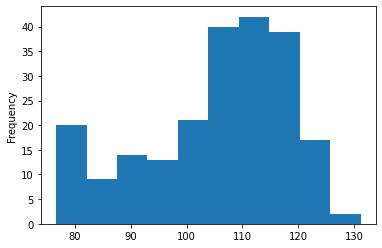

In [75]:
df.USD.plot.hist()

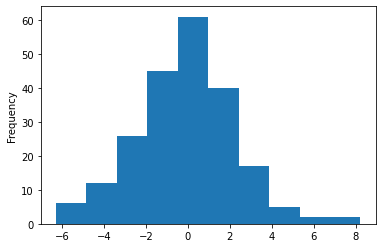

In [76]:
# 1次階差
# 階差をとることで値が欠損する行が生じるためdropna()でその行を削除する
df_diff1 = df.USD.diff().dropna()
# 1次階差系列のヒストグラムの表示
df_diff1.plot.hist()

In [77]:
import scipy.stats as stats

# 1次階差系列のShapiro-Wilk検定
stats.shapiro(df_diff1.values)

(0.9887570142745972, 0.08856895565986633)

In [78]:
# 原系列のShapiro-Wilk検定
stats.shapiro(df.USD.values)

(0.926977813243866, 6.659917506368629e-09)

上段に貼り付けているURLの書籍よると有意水準5%以上として、5%以上を正規分布としている。その上で一次階差が正規分布に従うとしているが、調べてみると5%以下が正規分布という見方が正しいようだ。  
そのため、両者とも正規分布には従っていないと言える。ただし、一次階差はp値8%なので正規分布に極めて近い。

#1-9-5 時間依存性の発見（自己相関の検定)
時系列データでは、観測した値と観測地点が記録されており、時系列データの分析では、各観測時点間の関係、つまり、データの並び順に意味を見出すことが目的の１つと言える。
自己相関係数は以下で表される。

$$
\dfrac {\sum ^{T}_{t=k+1}\left( y_{t}-\overline {y}\right) \left( y_{t-k}-\overline {y}\right) }{\sum ^{T}_{t=1}\left( y_{t}-\overline {y}\right) ^{2}}
$$



ラグkと自己相関係数の推移を確認するために、横軸にラグkをとり、縦軸に自己相関係数の値をプロットしたコレログラムと呼ばれる図を用いる。

In [82]:
# 自己相関
p_acf = sm.tsa.stattools.acf(passengers)

# 偏自己相関
p_pacf = sm.tsa.stattools.pacf(passengers, method='ols')
p_acf, p_pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


(array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
        0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
        0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
        0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
        0.4416288 , 0.45722376, 0.48248203, 0.51712699, 0.53218983,
        0.49397569, 0.43772134, 0.3876029 , 0.34802503, 0.31498388,
        0.28849682, 0.27080187, 0.26429011, 0.27679934, 0.2985215 ,
        0.32558712, 0.3370236 , 0.30333486, 0.25397708, 0.21065534,
        0.17217092]),
 array([ 1.        ,  0.95893198, -0.32983096,  0.2018249 ,  0.14500798,
         0.25848232, -0.02690283,  0.20433019,  0.15607896,  0.56860841,
         0.29256358,  0.8402143 ,  0.61268285, -0.66597616, -0.38463943,
         0.0787466 , -0.02663483, -0.05805221, -0.04350748,  0.27732556,
        -0.04046447,  0.13739883,  0.3859958 ,  0.24203808, -0.04912986,
        -0.19599778, -0.15443575,  0.04484465,  0.18371541, -0.090611

acf関数ではデフォルトでラグは40まで計算するようになっているため、グラフ表示も40に合わせる。

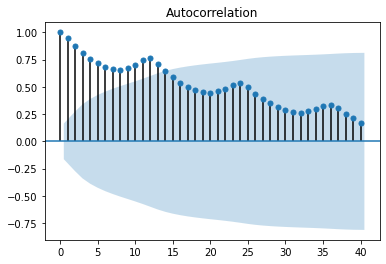

In [83]:
tmp = sm.graphics.tsa.plot_acf(passengers, lags=40)

ラグが大きくなるにつれて、自己相関係数の値は小さくなる傾向がある。青色の帯は95%信頼区間を示している。ラグ14までの自己相関係数は有意であり、14か月前の値とは相関関係が認められる。ただし、直接的に相関関係があると受け取ることはできない、  
例えばラグ1の自己相関関係がある場合

*   今月の値には先月の値が関係する
*   先月の値には先々月の値が関係する  

という推移関係が成り立つからである。  
推移関係を排除した自己相関係数はpacf関数で算出できる



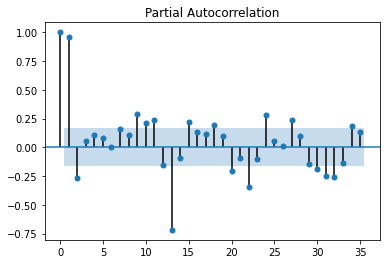

In [84]:
tmp = sm.graphics.tsa.plot_pacf(passengers, lags=35)

# 1.9.6 定常性(時系列データの性質)
時系列データ解析に適した前提条件を満たす確率過程には、弱定常性と強定常性の２つがある。
#### ◆弱定常性


*   平均が一定
*   分散が一定
*   自己共分散はラグkのみに依存する

#### ◆強定常性


*   任意のtとkに対しての同時分布が同一である

多くの経済・ファイナンスデータは弱定常性であるが、差分や対数差分を取ることで定常過程に近づけることが出来る。





In [0]:
df_logdiff_USD = (1 + df.USD.pct_change()).apply(np.log)

In [88]:
df.USD.div(df.USD.shift(1)) - 1

0           NaN
1     -0.035913
2     -0.023015
3     -0.044362
4      0.008725
5      0.012597
6      0.027948
7     -0.019201
8      0.005347
9     -0.028719
10     0.006065
11    -0.006447
12     0.009944
13    -0.021111
14     0.008695
15     0.003380
16     0.000842
17    -0.030295
18    -0.048685
19    -0.003558
20    -0.011993
21    -0.013899
22     0.001785
23     0.020073
24    -0.012690
25     0.047313
26    -0.026412
27    -0.000731
28     0.009141
29    -0.002989
         ...   
187   -0.000089
188    0.000797
189   -0.019285
190   -0.026069
191   -0.017505
192    0.012821
193    0.021500
194    0.002551
195    0.012360
196   -0.002693
197    0.007381
198    0.008132
199    0.004875
200   -0.007586
201   -0.031286
202    0.012845
203    0.007700
204    0.004405
205   -0.016737
206   -0.015838
207    0.001480
208   -0.018009
209    0.010533
210    0.006515
211    0.006935
212    0.003122
213    0.001373
214    0.005485
215   -0.022275
216    0.003906
Name: USD, Length: 217, 

In [89]:
df.USD.pct_change()

0           NaN
1     -0.035913
2     -0.023015
3     -0.044362
4      0.008725
5      0.012597
6      0.027948
7     -0.019201
8      0.005347
9     -0.028719
10     0.006065
11    -0.006447
12     0.009944
13    -0.021111
14     0.008695
15     0.003380
16     0.000842
17    -0.030295
18    -0.048685
19    -0.003558
20    -0.011993
21    -0.013899
22     0.001785
23     0.020073
24    -0.012690
25     0.047313
26    -0.026412
27    -0.000731
28     0.009141
29    -0.002989
         ...   
187   -0.000089
188    0.000797
189   -0.019285
190   -0.026069
191   -0.017505
192    0.012821
193    0.021500
194    0.002551
195    0.012360
196   -0.002693
197    0.007381
198    0.008132
199    0.004875
200   -0.007586
201   -0.031286
202    0.012845
203    0.007700
204    0.004405
205   -0.016737
206   -0.015838
207    0.001480
208   -0.018009
209    0.010533
210    0.006515
211    0.006935
212    0.003122
213    0.001373
214    0.005485
215   -0.022275
216    0.003906
Name: USD, Length: 217, 

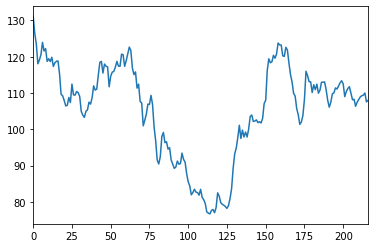

In [91]:
df.USD.plot()

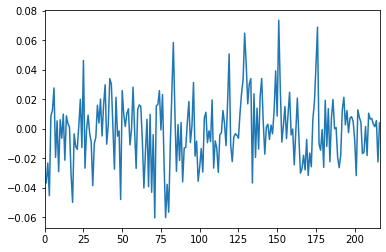

In [90]:
df_logdiff_USD.plot()